In [1]:
from socceraction.data.statsbomb import StatsBombLoader
import socceraction.spadl as spadl
import mplsoccer
import matplotlib.pyplot as plt
from statsbombpy import sb
import pandas as pd
import numpy as np
import tqdm as tq
from tqdm import tqdm

In [23]:
def loading_events(games):
    
    events = pd.DataFrame()
    
    for index, row in tq.tqdm(games.iterrows(), total=len(games)):
        ev = SBL.events(row['game_id'])
        ev_spadl = spadl.statsbomb.convert_to_actions(ev, row['home_team_id'])
        actions = (ev_spadl.merge(spadl.actiontypes_df(), on='type_id', how='inner')
                   .merge(SBL.teams(row['game_id']), on='team_id', how='inner')
                   .merge(SBL.players(row['game_id'])[['player_id','player_name']], on='player_id', how='inner')
                   .sort_values(['period_id','time_seconds'])
                   .reset_index(drop=True))
        actions = spadl.play_left_to_right(actions=actions, home_team_id=row['home_team_id'])
        events = pd.concat([events, actions], ignore_index=True)

    return events

In [68]:
sequences_dict = {}
action_id_dict = {}

sequence_counter = 0

def finding_sequences(row, team_id):

      global sequence_counter, last

      if row['team_id'] != team_id:
            if last == team_id:
                action_id_dict[sequence_counter] = action_id_dict.get(sequence_counter, []) + [row.name - 1]
            last = row['team_id']
            return None  # Não faz nada quando o team_id é -1

      if row['team_id'] == team_id:
            if last != team_id:
                sequence_counter += 1
                action_id_dict[sequence_counter] = action_id_dict.get(sequence_counter, []) + [row.name]
            last = team_id
            sequences_dict[sequence_counter] = sequences_dict.get(sequence_counter, []) + [row['type_id']]

      return None

## Loading Games

In [2]:
SBL = StatsBombLoader(getter="remote", creds={"user": None, "passwd": None})

In [11]:
competitions = SBL.competitions()

In [17]:
competition_id = 43
seasons = [106, 3]

selected_competitions = competitions[competitions.competition_name=='FIFA World Cup'][:2]
selected_competitions

,season_id,competition_id,competition_name,country_name,competition_gender,season_name
26,106,43,FIFA World Cup,International,male,2022
27,3,43,FIFA World Cup,International,male,2018


In [21]:
games = pd.concat([
    SBL.games(row.competition_id, row.season_id) 
    for row in selected_competitions.itertuples()
])

games[["home_team_id", "away_team_id", "game_date", "home_score", "away_score"]]

,home_team_id,away_team_id,game_date,home_score,away_score
0,786,773,2022-12-02 21:00:00,2,3
1,779,792,2022-12-03 21:00:00,2,1
2,792,776,2022-11-30 17:00:00,1,0
3,781,786,2022-11-24 21:00:00,2,0
4,777,792,2022-11-26 12:00:00,0,1
...,...,...,...,...,...
59,796,774,2018-06-19 20:00:00,3,1
60,796,785,2018-07-07 20:00:00,2,2
61,776,771,2018-06-26 16:00:00,0,0
62,778,787,2018-06-24 17:00:00,2,2


In [24]:
actions = loading_events(games)
brazil_games_actions = loading_events(games.query('home_team_id == 781 or away_team_id == 781').reset_index(drop=True))

100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [04:51<00:00,  2.28s/it]


In [48]:
brazil_actions = brazil_games_actions[brazil_games_actions.team_name=='Brazil']
brazil_actions.head()

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,type_name,team_name,player_name
0,3857258,dd455069-07ce-4acb-a490-81118fcb0235,1,0.0,781,3280.0,52.058824,34.430380,51.794118,37.270886,0,1,5,0,pass,Brazil,Richarlison de Andrade
1,3857258,bd74159d-a009-4ffb-bf61-e5755adf3d5f,1,1.0,781,4320.0,51.794118,37.270886,54.882353,40.025316,21,1,0,1,dribble,Brazil,Neymar da Silva Santos Junior
2,3857258,3ec348c7-e144-4c2a-8ad0-5c6e18199403,1,2.0,781,4320.0,54.882353,40.025316,44.470588,58.789873,0,1,5,2,pass,Brazil,Neymar da Silva Santos Junior
3,3857258,297470b5-a558-401d-a3f7-788b2e9c325d,1,4.0,781,6945.0,44.470588,58.789873,49.147059,60.425316,21,1,0,3,dribble,Brazil,Alex Sandro Lobo Silva
4,3857258,b3516a13-1244-4c4d-9d27-baf80949053b,1,6.0,781,6945.0,49.147059,60.425316,44.647059,47.944304,0,1,4,4,pass,Brazil,Alex Sandro Lobo Silva


## First insights

In [41]:
# Brazil's actions by player
print(brazil_actions.groupby('player_name').size().sort_values(ascending=False))

# Brazil's actions by type
print('\n\n\n\n', brazil_actions.groupby('type_name').size().sort_values(ascending=False))

player_name
Thiago Emiliano da Silva                   1218
Neymar da Silva Santos Junior              1125
Carlos Henrique Casimiro                   1010
Philippe Coutinho Correia                   701
Marcos Aoás Corrêa                          687
Danilo Luiz da Silva                        610
Marcelo Vieira da Silva Júnior              584
Éder Gabriel Militão                        534
João Miranda de Souza Filho                 511
Fágner Conserva Lemos                       438
Willian Borges da Silva                     434
Lucas Tolentino Coelho de Lima              386
Raphael Dias Belloli                        345
Gabriel Fernando de Jesus                   340
José Paulo Bezzera Maciel Júnior            338
Alex Sandro Lobo Silva                      335
Alisson Ramsés Becker                       281
Vinícius José Paixão de Oliveira Júnior     267
Antony Matheus dos Santos                   267
Rodrygo Silva de Goes                       249
Filipe Luís Kasmirski       

In [38]:
sa_actions = actions[actions.team_name=='Saudi Arabia']

In [39]:
# Saudi Arabia's actions by type
sa_actions.groupby('type_name').size().sort_values(ascending=False)

type_name
pass                2698
dribble             2537
throw_in             111
clearance            106
bad_touch            106
tackle               100
take_on              100
foul                  92
interception          85
shot                  57
cross                 48
goalkick              44
freekick_crossed      43
freekick_short        41
keeper_save           18
keeper_claim          14
corner_crossed        14
keeper_punch           8
shot_freekick          5
corner_short           4
shot_penalty           3
dtype: int64

## Finding Sequences

In [69]:
last = brazil_games_actions[['type_id','team_id', 'action_id']]['team_id'].iloc[0]

brazil_games_actions[['type_id','team_id', 'action_id']].apply(finding_sequences, axis=1, args=(781,))
action_id_dict[0] = [0, 15]
action_id_dict[1756] = [22434 ,22439]

In [80]:
# Number of brazi's sequences
sequence_counter+1

1757

In [103]:
action_id_dict

{0: [0, 15],
 1: [17, 20],
 2: [23, 23],
 3: [32, 32],
 4: [34, 38],
 5: [40, 69],
 6: [71, 85],
 7: [87, 91],
 8: [97, 102],
 9: [107, 108],
 10: [110, 110],
 11: [119, 119],
 12: [124, 127],
 13: [129, 141],
 14: [148, 150],
 15: [157, 160],
 16: [174, 174],
 17: [178, 196],
 18: [203, 203],
 19: [228, 234],
 20: [239, 239],
 21: [263, 280],
 22: [282, 284],
 23: [287, 315],
 24: [317, 317],
 25: [322, 330],
 26: [365, 365],
 27: [392, 392],
 28: [399, 412],
 29: [414, 420],
 30: [453, 454],
 31: [456, 458],
 32: [461, 461],
 33: [463, 463],
 34: [465, 475],
 35: [478, 492],
 36: [497, 497],
 37: [499, 500],
 38: [502, 510],
 39: [512, 540],
 40: [546, 552],
 41: [560, 566],
 42: [591, 591],
 43: [606, 606],
 44: [608, 610],
 45: [617, 619],
 46: [623, 643],
 47: [650, 659],
 48: [661, 678],
 49: [682, 706],
 50: [709, 712],
 51: [714, 718],
 52: [722, 724],
 53: [726, 756],
 54: [758, 758],
 55: [760, 764],
 56: [766, 772],
 57: [774, 775],
 58: [777, 801],
 59: [803, 804],
 60: [80

In [166]:
# Iterate over dict values and sum neymar sequence's participations
neymar_df = pd.DataFrame(columns=['in_sequence', 'shot', 'goal'])
neymar = 'Neymar da Silva Santos Junior'
index = 0

for i in action_id_dict.values():
    in_sequence = 0
    shot = 0
    goal = 0
    
    selected_rows = brazil_games_actions.iloc[i[0]:i[1]+1]
    involved = set(selected_rows.player_name)
    events = set(selected_rows.type_name)
    
    
    if(neymar in involved):
        in_sequence = 1
    if('shot' in events):
        shot = 1
    if(shot):
        results = set(selected_rows[selected_rows.type_name == 'shot'].result_id)
        if 1 in results:
            goal = 1
    
    neymar_df.loc[index] = [in_sequence, shot, goal]
    
    index += 1 

In [185]:
group_one = neymar_df[neymar_df.in_sequence == 1] # neymar in it
group_two = neymar_df[neymar_df.in_sequence == 0] # neymar not in it

In [188]:
group_one.shot.mean()

0.18259023354564755

In [189]:
group_two.shot.mean()

0.06998444790046657

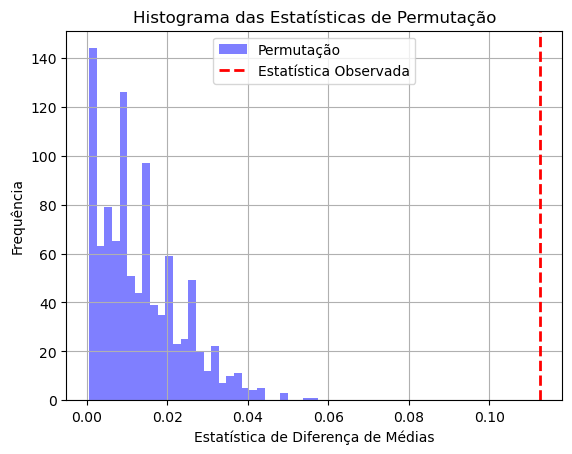

Valor p: 0.000999000999000999


In [193]:
# Crie uma função para calcular a estatística de interesse (nesse caso, a diferença entre as médias)
def test_statistic(data):
    group1 = data[data['in_sequence'] == 1]['shot']
    group2 = data[data['in_sequence'] == 0]['shot']
    return abs(np.mean(group1) - np.mean(group2))

# Calcule o valor p
observed_statistic = test_statistic(df)
num_permutations = 1000

# Realize o teste de permutação
permutation_stats = []
for _ in range(num_permutations):
    # Embaralhe a coluna 'in_sequence'
    shuffled_data = df.copy()
    shuffled_data['in_sequence'] = np.random.permutation(df['in_sequence'])
    
    # Calcule a estatística da permutação e a adicione à lista
    permutation_stat = test_statistic(shuffled_data)
    permutation_stats.append(permutation_stat)

# Calcule o valor p
p_value = (np.sum(np.array(permutation_stats) >= observed_statistic) + 1) / (num_permutations + 1)

# Plote um histograma das estatísticas de permutação
plt.hist(permutation_stats, bins=30, alpha=0.5, color='blue', label='Permutação')
plt.axvline(observed_statistic, color='red', linestyle='dashed', linewidth=2, label='Estatística Observada')

# Personalize o gráfico
plt.xlabel('Estatística de Diferença de Médias')
plt.ylabel('Frequência')
plt.title('Histograma das Estatísticas de Permutação')
plt.legend()
plt.grid(True)

# Exiba o gráfico
plt.show()

# Exiba o valor p
print("Valor p:", p_value)

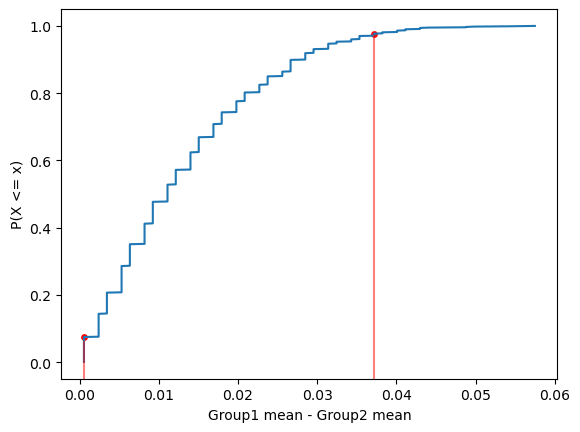

In [270]:
from statsmodels.distributions.empirical_distribution import ECDF

ecdf = ECDF(permutation_stats)
plt.plot(ecdf.x, ecdf.y)
plt.xlabel('Group1 mean - Group2 mean')
plt.ylabel('P(X <= x)')

percentile_2p5 = np.percentile(permutation_stats, 2.5)
percentile_97p5 = np.percentile(permutation_stats, 97.5)

plt.scatter(percentile_2p5, ecdf(percentile_2p5), color='red', marker='o', label='2.5th Percentile', s=15)
plt.scatter(percentile_97p5, ecdf(percentile_97p5), color='red', marker='o', label='2.5th Percentile', s=15)

plt.axvline(percentile_2p5, color='red', linestyle='-', label='2.5th Percentile Line', alpha=0.5, ymax=0.1)
plt.axvline(percentile_97p5, color='red', linestyle='-', label='2.5th Percentile Line', alpha=0.5, ymax=0.9275)


In [168]:
# Proportion of Neymar participation in Brazil's sequences
neymar_participations = len(neymar_df[neymar_df.in_sequence == 1])
p = np.round(neymar_participations / (sequence_counter+1), 3)
p

0.268